Fully Connected Feed-forward Neural Network

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from matplotlib.colors import ListedColormap
import seaborn as sn
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [16]:
def load_graphs(input_dir, class_dict) :

    data, data_labels = [], [] # data containing the graphs and data_labels the associated seizure type labels

    for szr_type in class_dict.keys() :
        szr_label = class_dict[szr_type]
        for _, _, files in os.walk(os.path.join(input_dir,szr_type)) :
            for npy_file in files :
                graph = np.load(os.path.join(input_dir,szr_type,npy_file))
                
                # Remove if not covariance matrices                
                #graph = graph/np.amax(graph.flatten())

                graph = graph[np.triu_indices(20, k = 1)]

                data.append(graph.flatten()) # graph has to be flattened to be fed to the classifier
                data_labels.append(szr_label)

    return np.array(data), np.array(data_labels)

def train_test_data(input_dir, class_dict) :

    train, train_labels = load_graphs(os.path.join(input_dir,'train'), class_dict)
    test, test_labels = load_graphs(os.path.join(input_dir,'dev'), class_dict)

    return train, test, train_labels, test_labels

In [17]:
input_dir = '../data/v1.5.2/graph_avg_1_5'
szr_types = ['FNSZ','GNSZ']

class_dict = {}
for i, szr_type in enumerate(szr_types) :
    class_dict[szr_type] = i

train, test, train_labels, test_labels = train_test_data(input_dir, class_dict)

In [19]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 50

trainset, testset = [], []
for i in range(len(train)) :
    trainset.append((train[i],train_labels[i]))
for j in range(len(test)) :
    testset.append((test[j],test_labels[j]))
classes = ('FNSZ','GNSZ')

#trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

#testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

#classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [20]:
print(trainset[0][0].shape)

(190,)


In [21]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(190, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x,dim=1)

In [22]:
FCNN = Net()
FCNN = FCNN.float()
print(FCNN)

Net(
  (fc1): Linear(in_features=190, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=2, bias=True)
)


In [23]:
gamma = 1e-5
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(FCNN.parameters(), lr=gamma)

In [24]:
total_L, total_acc = [], []
print('Batch_size : ',batch_size,'\nLearning rate : ',gamma)
for epoch in range(50): 
    for data in trainloader:  
        X, y = data
        FCNN.zero_grad()
        X, y = X.float(), y.type(torch.LongTensor)
        output = FCNN(X)
        #print('Output : \n',output,'\ny : \n',y)
        loss = loss_criterion(output, y)
        # Compute accuracy another way as the output is weights + bias and is continuous
        #total_acc.append(accuracy_score(output.detach().numpy(),y.detach().numpy()))
        loss.backward()
        optimizer.step() 
        total_L.append(loss)
    print(f"Loss : {loss}")


Batch_size :  50 
Learning rate :  1e-05
Loss : 0.6854793429374695
Loss : 0.6803584694862366
Loss : 0.6819068193435669
Loss : 0.6755963563919067
Loss : 0.6808556914329529
Loss : 0.6803159117698669
Loss : 0.6755267381668091
Loss : 0.6776796579360962
Loss : 0.6719005107879639
Loss : 0.673267126083374
Loss : 0.6695316433906555
Loss : 0.6673871278762817
Loss : 0.662070095539093
Loss : 0.6611308455467224
Loss : 0.6740933656692505
Loss : 0.6599613428115845
Loss : 0.6541373133659363
Loss : 0.6619194746017456
Loss : 0.664604902267456
Loss : 0.6566519141197205
Loss : 0.6645610928535461
Loss : 0.6696382761001587
Loss : 0.6539718508720398
Loss : 0.6420391201972961
Loss : 0.6643545627593994
Loss : 0.6516547203063965
Loss : 0.6519392132759094
Loss : 0.6695113778114319
Loss : 0.6486692428588867
Loss : 0.6450201869010925
Loss : 0.6555677056312561
Loss : 0.6450520157814026
Loss : 0.65360027551651
Loss : 0.6491826176643372
Loss : 0.6454473733901978
Loss : 0.6460304856300354
Loss : 0.6653456091880798
Lo

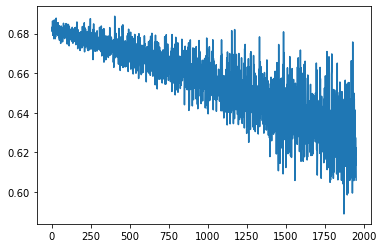

In [25]:
L_2 = [T.detach().numpy() for T in total_L]

L_2 = np.array(L_2)

plt.plot(L_2)
# batch_size 50, lr 1e-4
# Plot the accuracy